# Module Imports

Import the required modules for the following code.

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, fbeta_score, roc_auc_score 
from sklearn.model_selection import StratifiedKFold, GridSearchCV 
from imblearn.over_sampling import SMOTE, RandomOverSampler
from xgboost import XGBClassifier, Booster, DMatrix

# Suppress warning from deprecation of functions down below
import warnings
warnings.simplefilter(action='ignore')

# warnings.filterwarnings("ignore", category=FutureWarning)


## 1. Data Loading and Preliminary Exploration

In [2]:
# Load client csv
client_dataset = pd.read_csv('./client.csv')

# Load invoice csv
invoice_dataset = pd.read_csv('./invoice.csv')

# Basic exploration

print(client_dataset.head())
print(invoice_dataset.head())
print(client_dataset.describe())
print(invoice_dataset.describe())

   region        date  dis                 id  catg  target
0     101  31/12/1994   60     train_Client_0    11       0
1     107   29/5/2002   69     train_Client_1    11       0
2     301   13/3/1986   62    train_Client_10    11       0
3     105   11/7/1996   69   train_Client_100    11       0
4     303  14/10/2014   62  train_Client_1000    11       0
               id        date  tarif_type  counter_number  counter_statue   
0  train_Client_0   24/3/2014          11       1335667.0               0  \
1  train_Client_0   29/3/2013          11       1335667.0               0   
2  train_Client_0   23/3/2015          11       1335667.0               0   
3  train_Client_0   13/7/2015          11       1335667.0               0   
4  train_Client_0  17/11/2016          11       1335667.0               0   

   counter_code  reading_remarque  consommation_level_4  old_index  new_index   
0           203                 8                     0      14302      14384  \
1           203

## 2. Data Cleaning

Provided dataset contains a lot of clients that does not have any information. Ideally, we would like to clean out the clients that does not have any information before working on the data itself.

In [3]:
# Load client csv
client_dataset = pd.read_csv('./client.csv')

# Load invoice csv
invoice_dataset = pd.read_csv('./invoice.csv')

# Retrieve client IDs with valid invoice data
unique_client_ids = invoice_dataset['id'].unique()

# Filter client dataset to contain only those with invoice information
filtered_client_dataset = client_dataset[client_dataset['id'].isin(unique_client_ids)].copy()


Thereafter, we would split the datasets into test and training sets for further processing in later stages

In [4]:
# split client by target
client_0 = filtered_client_dataset[filtered_client_dataset['target'] == 0]
client_1 = filtered_client_dataset[filtered_client_dataset['target'] == 1]

# random sample 10% of client_0
client_0_test = client_0.sample(frac=0.1, random_state=42)
client_0_train = client_0[client_0.index.isin(client_0_test.index) == False]

client_1_test = client_1.sample(frac=0.1, random_state=42)
client_1_train = client_1[client_1['id'].isin(client_1_test['id']) == False]

# merge by target
client_train = pd.concat([client_0_train, client_1_train])
client_test = pd.concat([client_0_test, client_1_test])


# split invoice by client id
invoice_train = invoice_dataset[invoice_dataset['id'].isin(client_train['id'])]
invoice_test = invoice_dataset[invoice_dataset['id'].isin(client_test['id'])]

# save to csv
client_train.to_csv('./client_train_split.csv', index=False)
client_test.to_csv('./client_test_split.csv', index=False)
invoice_train.to_csv('./invoice_train_split.csv', index=False)
invoice_test.to_csv('./invoice_test_split.csv', index=False)

# read client_train_split.csv
client_data_train = pd.read_csv('./client_train_split.csv')

# read invoice_train_split.csv
invoice_data_train = pd.read_csv('./invoice_train_split.csv')

# read client_test_split.csv
client_data_test = pd.read_csv('./client_test_split.csv')

# read invoice_test_split.csv
invoice_data_test = pd.read_csv('./invoice_test_split.csv')

## 3. Feature Engineering

The main purpose of the following feature engineering function is to transform the raw invoice data into a more informative and aggregated format. By creating aggregated features at the `client_id` level, the ffunction captures overall behaviour of each client over time.

Features engineered are as follow:

- Data type conversion

- Extraction of information like month, year etc from invoice date for processing.

- Aggregation of invoice data for each client to get the sum, mean, max, and min of consumption levels, old and new index, month number, etc.

In [5]:
def invoice_drop(invoice_data):
    # Convert categorical data to numerical data
    invoice_data['counter_statue'] = invoice_data['counter_statue'].astype(
        'category').cat.codes.astype('int')

    # Deriving information form the invoice dates
    invoice_data['date'] = pd.to_datetime(invoice_data['date'], dayfirst=True)
    invoice_data['invoice_month'] = invoice_data['date'].dt.month
    invoice_data['invoice_year'] = invoice_data['date'].dt.year
    invoice_data['counter_type'] = invoice_data['counter_type'].astype('category').cat.codes.astype('int')
    invoice_data = invoice_data.drop(['date'], axis=1)

    # Index diff = consumption
    invoice_data['index_diff'] = invoice_data['new_index'] - invoice_data['old_index']

    # Getting the sum of the 4 consumption levels
    invoice_data['total_consumption'] = invoice_data[['consommation_level_1',
                                                      'consommation_level_2',
                                                      'consommation_level_3',
                                                      'consommation_level_4']].sum(axis=1)


    # Checking if numbers of the meter and the invoice are identical
    invoice_data['is_energy_equal'] = (invoice_data['total_consumption'] == invoice_data['index_diff'])

    # Renaming of columns for easier access and understanding
    def rename_cols(cols, prefix): return [f'{col}_{prefix}' for col in cols]


    # Aggregation by maximum
    invoice_max = invoice_data.groupby('id').max().astype('int')
    invoice_max.columns = rename_cols(invoice_max.columns, 'max')

    # Aggregation by minimum
    invoice_min = invoice_data.groupby('id').min().astype('int')
    invoice_min.columns = rename_cols(invoice_min.columns, 'min')

    # Aggregation by median
    invoice_median = invoice_data.groupby('id').median().astype('int')
    invoice_median.columns = rename_cols(invoice_median.columns, 'median')

    # Aggregation by lower quartile
    invoice_lower_quartile = invoice_data.groupby('id').quantile(.25).astype('int')
    invoice_lower_quartile.columns = rename_cols(invoice_lower_quartile.columns, 'lower_quartile')

    # Aggregation by upper quartile
    invoice_upper_quartile = invoice_data.groupby('id').quantile(.75).astype('int')
    invoice_upper_quartile.columns = rename_cols(invoice_upper_quartile.columns, 'q75')

    # Aggregation by std deviation
    invoice_std = invoice_data.groupby('id').std().notna().astype('int')
    invoice_std.columns = rename_cols(invoice_std.columns, 'std')

    # Aggregration by mean
    invoice_mean = invoice_data.groupby('id').mean().astype('int')
    invoice_mean.columns = rename_cols(invoice_mean.columns, 'mean')

    # Combining all aggregated features
    invoice_combined = pd.concat(
        [invoice_max, invoice_min, invoice_mean, invoice_median, invoice_std, invoice_lower_quartile,
        invoice_upper_quartile], axis=1)
    
    return invoice_combined

# Feature engineering invoice dataset
new_invoice_data_train = invoice_drop(invoice_data_train)
new_invoice_data_test = invoice_drop(invoice_data_test)

The main purpose of the following feature engineering is to ensure the client data is in correct format for modelling, as well as creating new features that might capture patterns better than the original ones. This includes aggregating or binning certain features to capture higher-level patterns.

Features engineered are as follow:

- Data type conversion

- Binning of `region` to broader categories to create new feature `region_group`. This helps to capture patterns that are more evident at a higher level or aggregated level, than at a granular level

In [6]:
count = 1

for client_data in [client_data_train, client_data_test]:
    client_data['catg'] = client_data['catg'].astype(
        'category').astype('int')
    client_data['dis'] = client_data['dis'].astype('category').astype('int')
    client_data['region'] = client_data['region'].astype('category').astype('int')
    client_data['region_group'] = client_data['region'].apply(
        lambda x: 100 if x < 100 else 390 if x > 390 else 300 if x > 300 else 200)
    client_data['region_group'] = client_data['region_group'].astype('category').astype('int')

    client_data['date'] = pd.to_datetime(client_data['date'], format='%d/%m/%Y')
    client_data['join_time'] = (
                (2019 - client_data['date'].dt.year) * 12 - client_data['date'].dt.month).astype(int)
    if count == 1:
        client_data['target'] = client_data['target'].astype('category').astype('int')
        count = 0

Let us define the following auxiliary helper functions to aid our processing of data better.

- `ranges` function: 

    Calculates the range and interquartile range (IQR). The IQR and range are measures of statistical dispersion, meaning they represent the spread of the data. The IQR measures the spread of the middle 50% of the data, while the range measures the spread of the entire dataset. These measures can be useful in understanding the variability of the data and can be particularly helpful in detecting outliers.

- `data_drop` function:

    Drops certain columns from the dataset. Columns being dropped have been identified as not useful based on domain knowledge, exploratory data analysis.



In [7]:
def ranges(data):
    for col in data.columns:
        if 'upperquartile' in col:
            data[col.replace('upperquartile', 'iqr')] = data[col] - data[col.replace('upperquartile', 'lowerquartile')]
        if 'max' in col:
            data[col.replace('max', 'range')] = data[col] - data[col.replace('max', 'min')]
    return data

def data_drop(data):
    data = data.drop(['id','date'], axis=1)
    data = data.drop([ 'consommation_level_3_min',
                       'consommation_level_4_min', 'counter_type_min',
                       'consommation_level_4_median', 'counter_statue_lower_quartile',
                       'consommation_level_3_lower_quartile',
                       'consommation_level_4_lower_quartile', 'counter_type_lower_quartile'], axis=1)
    
    return data

In [8]:
# Merge dataset to form full dataset
training_data = pd.merge(client_data_train, new_invoice_data_train, left_on='id', right_index=True)
test_data = pd.merge(client_data_test,new_invoice_data_test, left_on='id', right_index=True)

## 4. Data Preprocessing

Before creating the model, let us do the final steps of processing our data, prepping the data as input to our model.

In [9]:
# Utilise auxiliary helper functions to further process data
training_data = data_drop(ranges(training_data))
test_data = data_drop(ranges(test_data))
test_data = test_data.drop(['target'], axis=1)

# Split training data into x and y
x_train = training_data.loc[:, training_data.columns != 'target']
y_train = training_data.loc[:, training_data.columns == 'target']

Given that this is a fraud detection problem, it's likely that the dataset is imbalanced (i.e., many more non-fraudulent than fraudulent transactions) and in our dataset, it is this very case. 

Here, we would consider 2 possible methods to address the imbalanced dataset issue.

- SMOTE to handle the class imbalance. SMOTE generates synthetic samples in the feature space.

- RandomOverSampler to handle class imbalance. RandomOverSamplper simply replicates some of the instances of the minority class at random.

In [10]:
# Oversampling of the data

# SMOTE Approach
smote = SMOTE(sampling_strategy='auto', random_state=42)
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)

# RandomOverSampler Approach
x_train_ros, y_train_ros = RandomOverSampler(random_state=1234).fit_resample(x_train, y_train)

## 5. Model Building and Evaluation

We used a XGBoost classifier as the model of choice in this case. XGBoost is an optimized distributed gradient boosting library that employs the gradient boosting framework. At its core, it constructs an additive model in a forward stage-wise manner.


We begin by tuning the hyperparameters of the XGBoost model to optimize its performance. This tuning is done on a subset of the training data to expedite the process. Thereafter, we proceed with training the model itself.

After training the model, we then make predictions on the test set. In this case, we will be training 2 models, one on the SMOTE dataset, the other on the RandomOverSampler dataset.

**WARNING**: Tuning of hyperparameters using `xgboost_searching` function is very computationally intensive. We have provided a set of model parameters that we have derived on our own runs as below. Simply use the model param to train the model instead of running `xgboost_searching` to prevent undesired computational costs and unforeseen crashes.

In [11]:
# Param Training Function
def xgboost_searching(X,y, search_verbose=1):
    # Change Parameters here for testing
    params ={
        "gamma":[1.1, 1.2, 1.25, 1.3, 1.4],
        "max_depth":[2,3,4,5],
        "min_child_weight": [3,5,7,9],
        "subsample": [0.9, 1.0],
        "colsample_bytree": [0.6, 0.8, 1.0],
        "learning_rate": [0.2, 0.3, 0.4],
    }

    estimator = XGBClassifier(objective="binary:logistic", tree_method="hist", device="cuda",
                                eval_metric='auc', use_label_encoder=False)

    k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1000)

    grid_search = GridSearchCV(estimator=estimator, param_grid=params, scoring="roc_auc", n_jobs=-1, cv=k_fold.split(X,y), verbose=search_verbose)

    grid_search.fit(X,y)

    print("Best estimator: ")
    print(grid_search.best_estimator_)
    print("Parameters: ", grid_search.best_params_)
    print("Highest AUC: %.2f" % grid_search.best_score_)

    return grid_search.best_params_

# Parameter Training
# # Vanilla sample
# rowsk = random.sample(np.arange(0,len(x_train.index)).tolist(), 1000)
# model_param = xgboost_searching(x_train.iloc[rowsk,], y_train.iloc[rowsk,])
# print(model_param)

# # Oversample
# rowsk1 = random.sample(np.arange(0,len(x_train_smote.index)).tolist(), 1000)
# model_param_smote = xgboost_searching(x_train_smote.iloc[rowsk1,], y_train_smote.iloc[rowsk1,])
# print(model_param_smote)

# rowsk2 = random.sample(np.arange(0,len(x_train_ros.index)).tolist(), 1000)
# model_param_ros = xgboost_searching(x_train_ros.iloc[rowsk2,], y_train_ros.iloc[rowsk2,])
# print(model_param_ros)

model_param = {'colsample_bytree': 1.0, 'gamma': 1.1, 'learning_rate': 0.4, 'max_depth': 3, 'min_child_weight': 9, 'subsample': 1.0}
model_param_smote = {'colsample_bytree': 0.8, 'gamma': 1.4, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.9}
model_param_ros = {'colsample_bytree': 0.8, 'gamma': 1.25, 'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.9}

# Model Training
# Vanilla Model (No Oversampling)
model = XGBClassifier(objective="binary:logistic", eval_metric='auc', use_label_encoder=False)
model.set_params(**model_param)
model.fit(x_train,y_train)

# SMOTE Model
model_smote = XGBClassifier(objective="binary:logistic", eval_metric='auc', use_label_encoder=False)
model_smote.set_params(**model_param_smote)
model_smote.fit(x_train_smote,y_train_smote)

# ROS Model
model_ros = XGBClassifier(objective="binary:logistic", eval_metric='auc', use_label_encoder=False)
model_ros.set_params(**model_param_ros)
model_ros.fit(x_train_ros,y_train_ros)

y_pred = model.predict(test_data)
y_pred_smote = model_smote.predict(test_data)
y_pred_ros = model_ros.predict(test_data)
# predict_df = pd.DataFrame({'id': client_data_test['id'], 'target': y_pred})
y_test = client_data_test['target']

We evaluate the 2 models using various metrics like accuracy, precision, recall, F1 score, and ROC AUC score. Given that this is a fraud detection problem, metrics like precision, recall, and F1 score are particularly important because they give us insights into the model's performance on the positive (fraud) class.

#### Vanilla Model (No Oversampling)

Accuracy: 0.9436887061056628
Precision: 0.475
Recall: 0.10795454545454546
F1 Score: 0.17592592592592593
F2 Score: 0.12768817204301078
ROC AUC Score: 0.5504596847875742
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      2985
           1       0.47      0.11      0.18       176

    accuracy                           0.94      3161
   macro avg       0.71      0.55      0.57      3161
weighted avg       0.92      0.94      0.93      3161



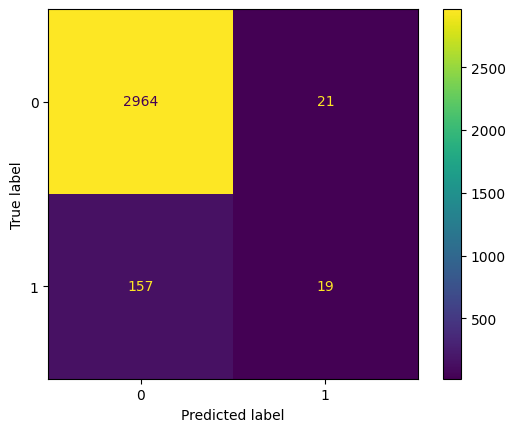

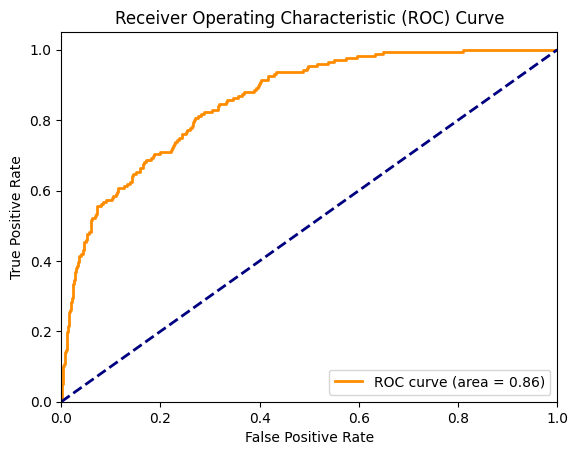

In [12]:
# Evaluation of vanilla model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("F2 Score:", fbeta_score(y_test, y_pred, beta=2))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred))

# Print Classification Report
print(classification_report(y_test, y_pred))

# For better visualisation
# 1. Plotting the Confusion Matrix
cm_display = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

# 2. ROC Curve and AUC
y_prob = model.predict_proba(test_data)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


#### SMOTE Evaluation

Accuracy: 0.9259727934198039
Precision: 0.31875
Recall: 0.2897727272727273
F1 Score: 0.30357142857142855
F2 Score: 0.2951388888888889
ROC AUC Score: 0.6266284071874524
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      2985
           1       0.32      0.29      0.30       176

    accuracy                           0.93      3161
   macro avg       0.64      0.63      0.63      3161
weighted avg       0.92      0.93      0.92      3161



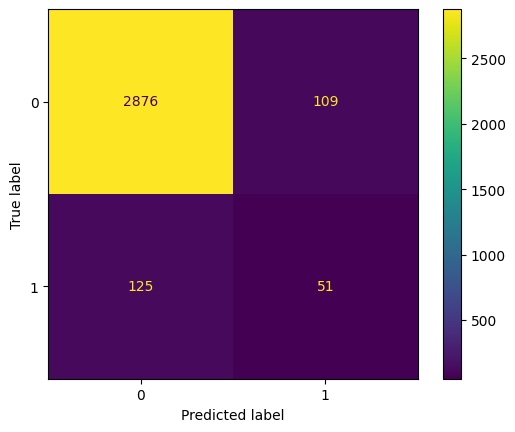

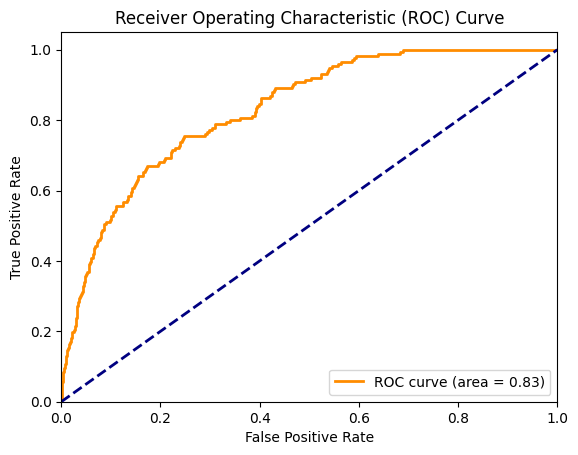

In [13]:
# Evaluation of SMOTE
print("Accuracy:", accuracy_score(y_test, y_pred_smote))
print("Precision:", precision_score(y_test, y_pred_smote))
print("Recall:", recall_score(y_test, y_pred_smote))
print("F1 Score:", f1_score(y_test, y_pred_smote))
print("F2 Score:", fbeta_score(y_test, y_pred_smote, beta=2))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_smote))

# Print Classification Report
print(classification_report(y_test, y_pred_smote))

# For better visualisation
# 1. Plotting the Confusion Matrix
cm_display = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_smote)

# 2. ROC Curve and AUC
y_prob = model_smote.predict_proba(test_data)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


#### RandomOverSampler Evaluation

Accuracy: 0.8892755457133819
Precision: 0.2661290322580645
Recall: 0.5625
F1 Score: 0.3613138686131387
F2 Score: 0.46003717472118955
ROC AUC Score: 0.7355213567839196
              precision    recall  f1-score   support

           0       0.97      0.91      0.94      2985
           1       0.27      0.56      0.36       176

    accuracy                           0.89      3161
   macro avg       0.62      0.74      0.65      3161
weighted avg       0.93      0.89      0.91      3161



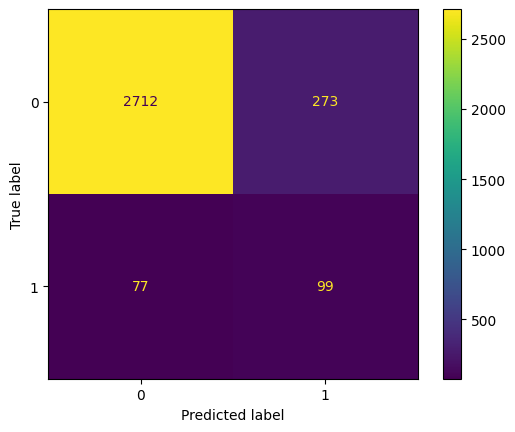

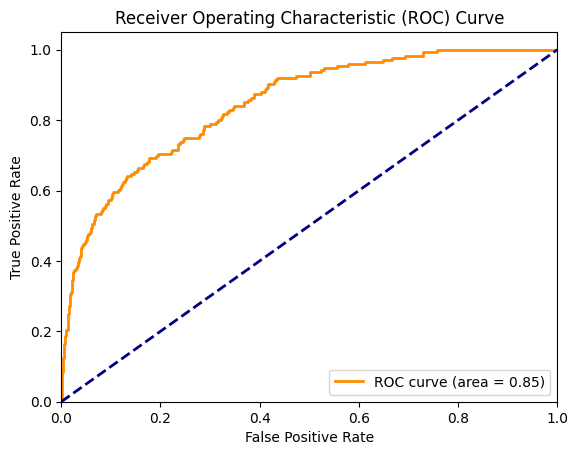

In [14]:
# Evaluation of SMOTE
print("Accuracy:", accuracy_score(y_test, y_pred_ros))
print("Precision:", precision_score(y_test, y_pred_ros))
print("Recall:", recall_score(y_test, y_pred_ros))
print("F1 Score:", f1_score(y_test, y_pred_ros))
print("F2 Score:", fbeta_score(y_test, y_pred_ros, beta=2))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_ros))

# Print Classification Report
print(classification_report(y_test, y_pred_ros))

# For better visualisation
# 1. Plotting the Confusion Matrix
cm_display = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_ros)

# 2. ROC Curve and AUC
y_prob = model_ros.predict_proba(test_data)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
